<img src="images/00-image.png" alt="encoder" class="bg-primary" width="100%">


 [Image Reference](https://www.planetware.com/tourist-attractions-/potsdam-d-br-pt.htm)

<h1><center> Vision Transformer <center></h1>

Vision Transformer (ViT) paper: [Paper Reference](https://arxiv.org/abs/2010.11929)

-------

In [1]:
import os
import shutil
import numpy as np
import pandas as pd

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchinfo import summary # pip
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix #pip
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from mlxtend.plotting import plot_confusion_matrix #pip

import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical

In [4]:
from numpy import expand_dims, moveaxis
from numpy import asarray
from PIL import Image

In [5]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.0
torchvision version: 0.17.0


In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
input_size = 64
num_heads = 4

# Generate some random input tensors for values, keys, and queries
values = torch.rand(10, 32, input_size)  # (batch_size, sequence_length, input_size)
keys = torch.rand(10, 32, input_size)
queries = torch.rand(10, 32, input_size)
mask = torch.rand(10, 1, 1, 32) 

In [8]:
values.shape

torch.Size([10, 32, 64])

#

## 1. Vision Transformer Introduction

### ViT Architecture : Figure 1

<img src="images/01-vitpaper.png" alt="encoder" class="bg-primary" width="60%">


Component ViT Architecture:
* **Inputs** - What goes into the model? (image sequence as tensors)
* **Outputs** - What comes out of the model/layer/block? (image classification labels)
* **Layers** - Takes an input, manipulates it with a function (E.g : self-attention)
* **Blocks** - Collection of layers
* **Model** - Collection of blocks

Embedding are learnable representation (we start with random numbers and it improve over time) 

#

### Four equations introduction
<img src="images/03-vitpaper_4equations.png" alt="encoder" class="bg-primary" width="60%">

* Four equations: Equations that explain the Model architecture

#

### Different Sizes of Architecture based on Hyper-parameters

<img src="images/02-vitpaper_table.png" alt="encoder" class="bg-primary" width="60%">

* ViT-Base, ViT-Large and ViT-Huge represent different model sizes
* ViT-B/16 = ViT-Base with image patch size 16x16 will be implemented
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size / latent space dimension
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 

#

### 1.1 Visualize a single image

In [9]:
# Create image size 
img_size = 224 # comes from Table 3 of the ViT paper

data_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                     transforms.ToTensor()])

print(data_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Cat')

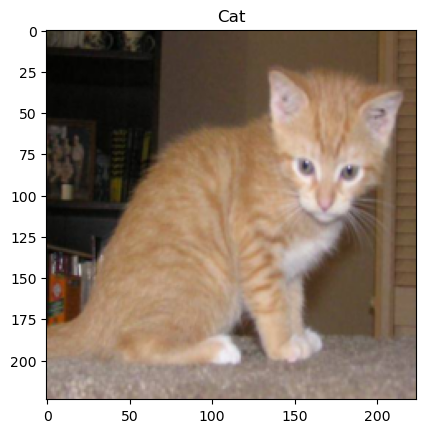

In [15]:
img = Image.open('predict_image.jpg')
image = data_transform(img)

label = ['Cat']
print(f"Image shape: {image.shape}")
plt.imshow(np.transpose(image, (1, 2, 0))) # image shape is [3, 224,224] (colour channels, height, width)
plt.title(label[0])

#

## 2. Implementation of the four major equations 

### Four equations

<img src="images/03-vitpaper_4equations.png" alt="encoder" class="bg-primary" width="60%">

### 2.1 Equation 1: Split data into patches and creating the class, position and patch embedding

> **Equation 1:**
Transformer requires as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches. The Transformer uses constant latent vector size $D$ through all of its layers. Thus we create latent space of $D$ dimensions with a trainable linear projection.
- Class token is prepended to the patch embedding, increasing the dimension to $N + 1$
- Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings.


* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* P = patch size
* N = number of patches = $(H * W) / P^{2}$
* D = constant latent vector size = embedding dimension

In [16]:
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Required number of patches
no_required_patches = int((height * width) / patch_size**2)
no_required_patches

196

In [17]:
# Embedding input shape
input_shape = (height, width, color_channels)

# Embedding output shape
output_shape = (no_required_patches, patch_size**2 * color_channels)

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape} -> (number_of_patches, embedding_dimension)")

Input shape: (224, 224, 3)
Output shape: (196, 768) -> (number_of_patches, embedding_dimension)


#### 2.1.1 Visualizing image as patches

Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Cat')

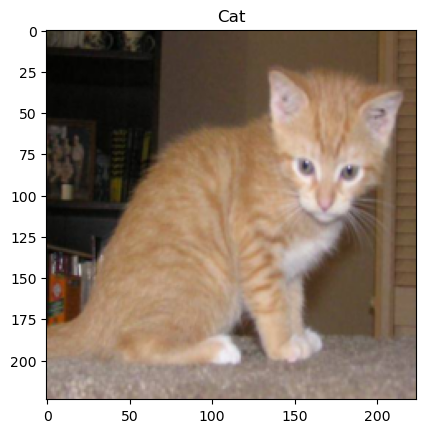

In [18]:
img = Image.open('predict_image.jpg')
image = data_transform(img)

label = ['Cat']
print(f"Image shape: {image.shape}")
plt.imshow(np.transpose(image, (1, 2, 0))) # image shape is [3, 224,224] (colour channels, height, width)
plt.title(label[0])

Expected number of patches: 14


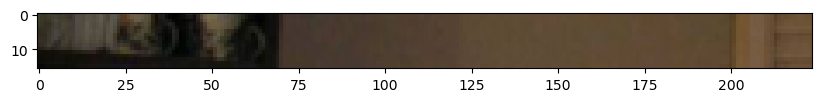

In [19]:
image_permuted = image.permute(1, 2, 0) # convert image to (H, W, C) dimension


patch_size = 16

# Image size must be divisible by patchsize
print(f'Expected number of patches: {int(224/16)}') 

plt.figure(figsize=(10,10))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14
Each patch size: 16 pixels x 16 pixels


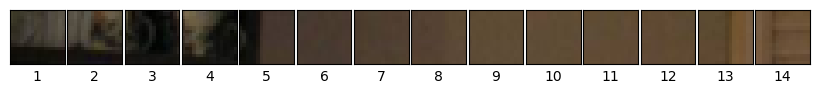

In [20]:
# Visualizing slice of patches
img_size = 224
patch_size = 16
num_patches = int(img_size/patch_size)

print(f"Number of patches per row: {num_patches}\nEach patch size: {patch_size} pixels x {patch_size} pixels")


# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols= img_size // patch_size, # Image size must be divisible by patchsize
                        sharex=True,
                        sharey=True,
                        figsize=(10,10))


fig.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.05, hspace=0.05)
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Total patches: 196 
Each patch size: 16 pixels x 16 pixels


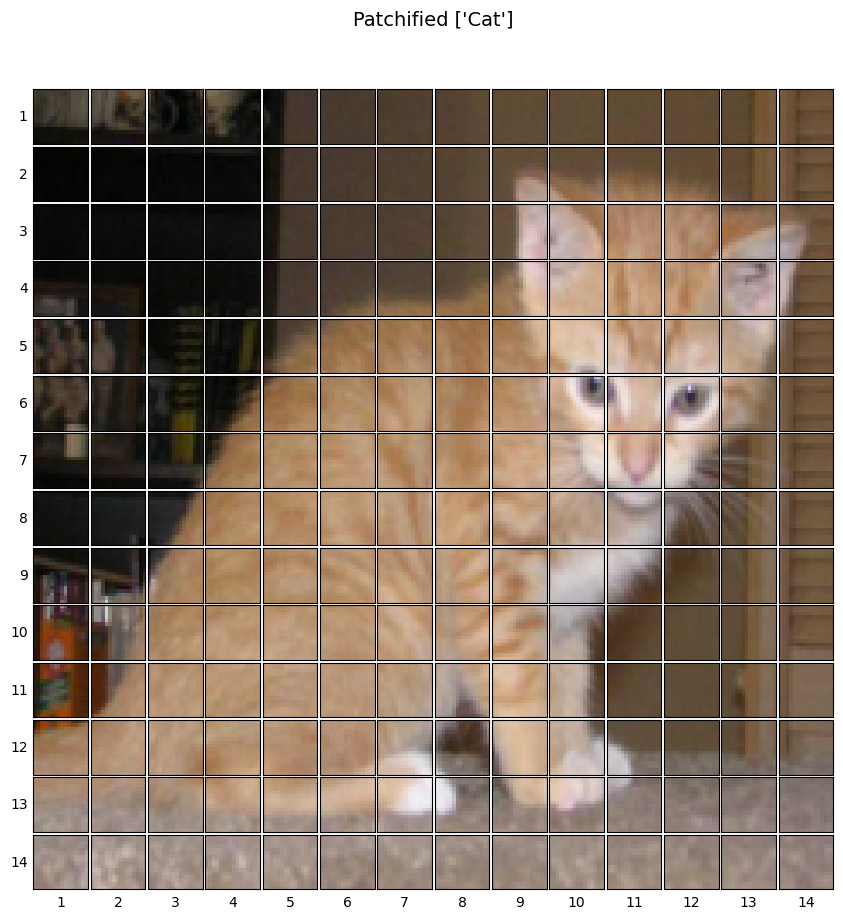

In [21]:
# Visualizing all patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
print(f"Total patches: {int(num_patches*num_patches)} \nEach patch size: {patch_size} pixels x {patch_size} pixels")


fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(10,10),
                        sharex=True,
                        sharey=True)

fig.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.05, hspace=0.05)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  patch_width:patch_width+patch_size, :])
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
fig.suptitle(f"Patchified {label}", fontsize=14)
plt.show()

#### 2.1.2 Creating patch embeddings

We can create the same patches using `torch.nn.Conv2d()`, setting the kernel size and stride parameters to `patch_size`. 

In [22]:
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # hidden size D from Table 1 for ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Cat')

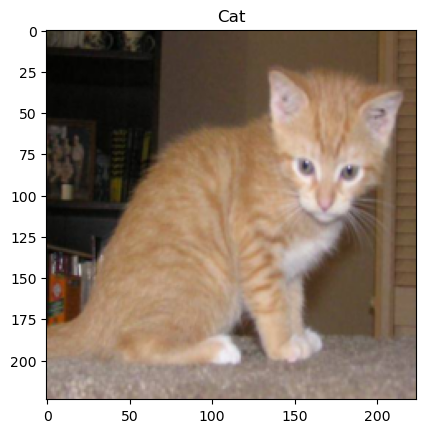

In [23]:
img = Image.open('predict_image.jpg')
image = data_transform(img)

label = ['Cat']
print(f"Image shape: {image.shape}")
plt.imshow(np.transpose(image, (1, 2, 0))) # image shape is [3, 224,224] (colour channels, height, width)
plt.title(label[0])

In [24]:
# Generate an example
conv2d_image = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, 786 (neuron), color_channels, height, width)
print(conv2d_image.shape) 

torch.Size([1, 768, 14, 14])


In [25]:
#conv2d_image.requires_grad

Now we've passed a single image to our `conv2d` layer, it's shape becomes: 

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_image_height, feature_image_width] 
```

Showing few feature maps using random indexes: [258, 345, 423, 475, 505, 0, 498, 250]


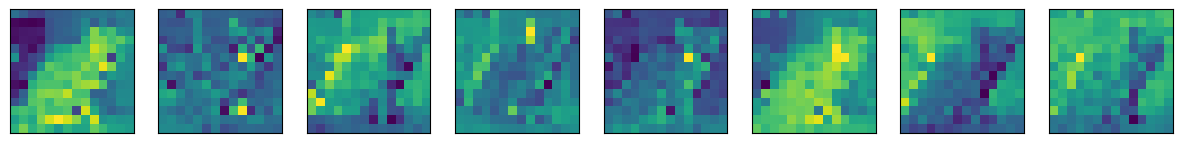

In [26]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=8)
print(f"Showing few feature maps using random indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(15, 15))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = conv2d_image[:, idx, :, :] # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [27]:
# Get a single feature map in tensor form
single_feature_map = conv2d_image[:, 0, :, :] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.1128,  0.1554,  0.0087,  0.1401,  0.0305,  0.0885,  0.0965,
            0.1200,  0.1273,  0.1303,  0.1332,  0.1222,  0.1667,  0.1425],
          [-0.0109, -0.0027,  0.0054,  0.0105,  0.0274,  0.0881,  0.1027,
            0.1197,  0.1749,  0.1189,  0.1172,  0.0998,  0.1412,  0.1397],
          [-0.0056, -0.0053, -0.0034,  0.0065,  0.0339,  0.0951,  0.0952,
            0.1207,  0.2044,  0.2808,  0.2121,  0.2322,  0.1744,  0.1325],
          [-0.0127, -0.0046,  0.0012,  0.0046,  0.0520,  0.0944,  0.0925,
            0.1369,  0.2302,  0.2955,  0.2304,  0.2616,  0.2706,  0.1905],
          [ 0.0543,  0.0616, -0.0009,  0.0244,  0.1208,  0.1684,  0.2068,
            0.2204,  0.2338,  0.3763,  0.2575,  0.2680,  0.2083,  0.1624],
          [ 0.1191,  0.0541,  0.1164,  0.1107,  0.1651,  0.2222,  0.2339,
            0.2532,  0.2434,  0.3678,  0.3716,  0.2710,  0.2341,  0.1232],
          [ 0.0334,  0.0588,  0.0712,  0.1200,  0.2413,  0.2482,  0.2030,
            0.2394,  0.3009,  0.

#### 2.1.3 Flattening the patch embedding with `torch.nn.Flatten()`

- Converting each feature maps into a sequence of patch embeddings using flatten to satisfy the input criteria of the ViT Transformer Encoder.

In [28]:
print(f"{conv2d_image.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [29]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(conv2d_image).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


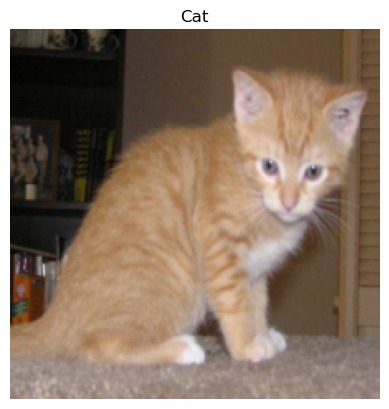

In [32]:
# In general: patch embedding
plt.imshow(image.permute(1, 2, 0))
plt.title(label[0])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
conv2d_image = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {conv2d_image.shape}")

# Flatten the feature maps
conv2d_image_flattened = flatten_layer(conv2d_image)
print(f"Flattened image feature map shape: {conv2d_image_flattened.shape}")

In [33]:
# Rearrange output of flattened layer
conv2d_image_flattened_permuted = conv2d_image_flattened.permute(0, 2, 1)
print(f"{conv2d_image_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


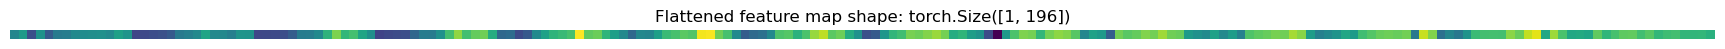

In [34]:
# Get a single flattened feature map
single_flattened_feature_map = conv2d_image_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False); 

#### 2.1.4 Creating a patch embedding layer block

In [35]:
class Patch_Embeddings(nn.Module):

    def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
        super().__init__()

        self.patch_size = patch_size


        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):

        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        patched_img = self.patcher(x) 
        flattened_img = self.flatten(patched_img)
        
        return flattened_img.permute(0, 2, 1)

In [36]:
# An example
patchify = Patch_Embeddings(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [37]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)

tensor([[[ 0.8645,  0.4174, -0.3322,  ..., -0.3346, -0.0139,  0.3188],
         [ 0.7955,  0.4169, -0.3935,  ..., -0.7389, -0.7486,  0.3705],
         [ 0.8026,  0.9082, -0.0502,  ...,  0.4980, -0.2247, -1.1096],
         ...,
         [-0.3049,  0.2692, -0.0227,  ..., -0.7974, -0.8194,  0.7283],
         [ 0.1874, -0.6303, -0.1030,  ..., -0.0088, -0.7361, -1.1164],
         [-0.2151, -1.0592, -0.2561,  ..., -0.5593,  1.1036,  0.3089]]],
       grad_fn=<PermuteBackward0>)

#

#### 2.1.5 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [38]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [39]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [40]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [41]:
# Prepend a class token embedding to the patch embedding 
patch_and_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(patch_and_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_and_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.1848,  0.0434, -0.0854,  ..., -0.1771, -0.0549, -0.2263],
         [ 0.1947,  0.0503, -0.0532,  ..., -0.1877, -0.0494, -0.1720],
         ...,
         [ 0.5566,  0.2072, -0.1651,  ..., -0.2156,  0.0235, -0.3672],
         [ 0.5758,  0.2277, -0.1644,  ..., -0.2424,  0.0569, -0.3670],
         [ 0.5368,  0.1918, -0.1804,  ..., -0.2172,  0.0470, -0.3587]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


#

#### 2.1.6 Creating the position embedding

- Create a series of 1D learnable position embeddings, add to patch embeddings to preserve the positional inofrmation.

In [42]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_and_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, # to account for additional token (class token)
                                             embedding_dimension),
                                  requires_grad=True)

In [43]:
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [44]:
patch_and_class_embedding, patch_and_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.1848,  0.0434, -0.0854,  ..., -0.1771, -0.0549, -0.2263],
          [ 0.1947,  0.0503, -0.0532,  ..., -0.1877, -0.0494, -0.1720],
          ...,
          [ 0.5566,  0.2072, -0.1651,  ..., -0.2156,  0.0235, -0.3672],
          [ 0.5758,  0.2277, -0.1644,  ..., -0.2424,  0.0569, -0.3670],
          [ 0.5368,  0.1918, -0.1804,  ..., -0.2172,  0.0470, -0.3587]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [45]:
# Add the position embedding to the patch and class token embedding
full_embedding = patch_and_class_embedding + position_embedding
print(full_embedding)
print(f"Full embedding shape: {full_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.1848, 1.0434, 0.9146,  ..., 0.8229, 0.9451, 0.7737],
         [1.1947, 1.0503, 0.9468,  ..., 0.8123, 0.9506, 0.8280],
         ...,
         [1.5566, 1.2072, 0.8349,  ..., 0.7844, 1.0235, 0.6328],
         [1.5758, 1.2277, 0.8356,  ..., 0.7576, 1.0569, 0.6330],
         [1.5368, 1.1918, 0.8196,  ..., 0.7828, 1.0470, 0.6413]]],
       grad_fn=<AddBackward0>)
Full embedding shape: torch.Size([1, 197, 768])


#### 2.1.7 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's it all in one cell.

In [46]:
# In general: Full embedding
# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = Patch_Embeddings(in_channels=3,
                                         patch_size=patch_size, 
                                         embedding_dim=768)

# 5. Pass input image through Patch_Embeddings
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
full_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {full_embedding.shape} ")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) 


#

### 2.2 Equation 2: Multihead Self-Attention (MSA block)

**Equations 2:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A)

*Self Attention* $Y=\underbrace{\operatorname{softmax}\left(Q K^{\top}\right)}_{\text {Attention matrix } A} V$


*Scale Factor*  = $\frac{1}{\sqrt{D_{\text {model }}}}$

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  *  Multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.


* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.

In [47]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, embed_dim, head_size, dropout):
        super().__init__()
        self.key = nn.Linear(embed_dim, head_size, bias=False)
        self.query = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        # input of size (batch, latent-space, feature map)
        # output of size (batch, latent-space, head size)
        
        B,T,C = key.shape
        
        key = self.key(key)   # (B,T,hs)
        query = self.query(query) # (B,T,hs)
        
        # compute attention scores ("affinities")
        weight = query @ key.transpose(-2,-1) # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        
        weight = weight * key.shape[-1]**-0.5 # Scale Factor

        weight = weight.masked_fill(torch.tril(torch.ones(T,T)) == 0, float('-inf'))# (B, T, T)
        
        weight = F.softmax(weight, dim=-1) # (B, T, T)
        
        weight = self.dropout(weight)
        
        # perform the weighted aggregation of the values
        value = self.value(value) # (B,T,hs)
        out = weight @ value # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        
        return out

In [48]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        
        head_size = embed_dim // num_heads
        
        self.heads = nn.ModuleList([Head(embed_dim, head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        output = torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        
        output = self.dropout(self.proj(output))
        
        return output

In [49]:
class MSAttention_Block(nn.Module): 
    """Creates a multi-head self-attention block
    """
    def __init__(self, embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0): # Heads from Table 1 for ViT-Base
        super().__init__()
        
        # Layer Norm (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Multihead attention (MSA) layer
        self.multihead_attn = MultiHeadAttention(embed_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 dropout=attn_dropout)
        '''
        # Multihead attention (MSA) layer -- In built in PyTorch
        self.multihead_attn2 = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout, 
                                                    batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
        '''
        
    def forward(self, x):
        x = self.layer_norm(x)
        
        attn_output = self.multihead_attn(query=x,
                                          key=x,
                                          value=x)
        
        '''    
        attn_output, _ = self.multihead_attn2(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        '''
        return attn_output

###

In [50]:
# Create an instance MSA block
multihead_self_attention_block = MSAttention_Block(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(full_embedding)
print(f"Input shape of MSA block: {full_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


#

#

### 2.3 Equation 3: Multilayer Perceptron (MLP block)

In [51]:
class MLP_Block(nn.Module):
    def __init__(self, embedding_dim:int=768, mlp_size:int=3072, dropout:float=0.1):
        super().__init__()

        # Create the norm layer (LN) 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim, out_features=mlp_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=mlp_size,
                                           out_features=embedding_dim), # squeezed back to the embedding dimension as seen in the next cell (shape)
                                 nn.Dropout(p=dropout))                 # drop out or activation fn does not chage dimension

    def forward(self, x):
        
        return self.mlp(self.layer_norm(x))

In [52]:
# Create an instance of MLPBlock
mlp_block = MLP_Block(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLP_Block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"MLP block input shape: {patched_image_through_msa_block.shape}")
print(f"MLP block output shape: {patched_image_through_mlp_block.shape}")

MLP block input shape: torch.Size([1, 197, 768])
MLP block output shape: torch.Size([1, 197, 768])


### 2.4 Equation 4: Linear Layer

**Equation 4:**
Linear layer to act as the classifier

#

## 3. Putting all together - A Transformer Encoder block

* **Encoder** :  to turn a sequence into learnable representation
* The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).
* And there are residual connections between each block.

In [53]:
class Transformer_Encoder_Block(nn.Module):
    def __init__(self,
           embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
           num_heads:int=12, # from table 1
           mlp_size:int=3072, # from table 1
           mlp_dropout:float=0.1, # from table 3
           attn_dropout:float=0):
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MSAttention_Block(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Create MLP block (equation 3)
        self.mlp_block = MLP_Block(embedding_dim=embedding_dim, 
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
    
    def forward(self, x):
        x = self.msa_block(x) + x # residual/skip connection for equation 2
        x = self.mlp_block(x) + x # residual/skip connection for equation 3
        return x 

In [54]:
#!pip install torchinfo

In [55]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = Transformer_Encoder_Block()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
Transformer_Encoder_Block (Transformer_Encoder_Block)   [1, 197, 768]        [1, 197, 768]        --                   True
├─MSAttention_Block (msa_block)                         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiHeadAttention (multihead_attn)              --                   [1, 197, 768]        --                   True
│    │    └─ModuleList (heads)                          --                   --                   1,769,472            True
│    │    └─Linear (proj)                               [1, 197, 768]        [1, 197, 768]        590,592              True
│    │    └─Dropout (dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─MLP

#

## 4. Putting all together - A complete Vision Transformer

In [56]:
# Create a complete Vision Transformer Model Architecture
class Vision_Transformer(nn.Module): 
    def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16, 
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
        super().__init__()

        # Make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

        # Calculate the number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # Create learnable position embedding 
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = Patch_Embeddings(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Create the Transformer Encoder block ... create stacked
        self.transformer_encoder = nn.Sequential(*[Transformer_Encoder_Block(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # Create classifier head
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))
        
        
  
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x

        # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
        x = self.embedding_dropout(x)

        # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0th index logit through classifier (equation 4)
        print(f'Old: {x.shape}')
        print(f'New: {x[:, 0].shape}')
        
        x = self.classifier(x[:, 0])

        return x 

In [57]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [58]:
#set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = Vision_Transformer(num_classes=1)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)[-1]

Old: torch.Size([1, 197, 768])
New: torch.Size([1, 768])


tensor([-0.4143], grad_fn=<SelectBackward0>)

#

# 5. Training Our Model

In [60]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
#from src import data_prep will try this after I create an installable package
from src import model

### 5.1 Data Preparation

In [61]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    directory_ = os.listdir(directory)
    
    for i in directory_:
        #path = os.listdir(directory + folder)
        if i.startswith('.') or i.startswith('_'):
            directory_.remove(i)
        
    for folder in directory_:
        for filename in os.listdir(directory+folder):
            image_path = os.path.join(directory, folder, filename)

            if filename.startswith('.') or filename.startswith('_') or filename[-4:] != '.jpg':
                pass

            else:
                image_paths.append(image_path)
                labels.append(folder)
        
    return image_paths, labels

In [62]:
# Setup directory paths to train and test images
train_directory = "src/archive/train/"
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_directory)

# shuffle the dataset
control = 'label'
random_order = np.random.permutation(len(train))
train['RandomOrder'] = random_order
train = train.sort_values(by=['RandomOrder', control]).reset_index(drop=True)
train = train.drop(columns=['RandomOrder'])
class_names = ['Bird','Cat', 'Dog']

train.head()

,image,label
0,src/archive/train/dogs/miniature_pinscher_21.jpg,dogs
1,src/archive/train/birds/PINK_ROBIN_006.jpg,birds
2,src/archive/train/birds/KOOKABURRA_111.jpg,birds
3,src/archive/train/dogs/chihuahua_33.jpg,dogs
4,src/archive/train/birds/JABIRU_002.jpg,birds


In [63]:
test_directory = "src/archive/test/"
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_directory)

# shuffle the dataset
control = 'label'
random_order = np.random.permutation(len(test))
test['RandomOrder'] = random_order
test = test.sort_values(by=['RandomOrder', control]).reset_index(drop=True)
test = test.drop(columns=['RandomOrder'])
test.head()

,image,label
0,src/archive/test/dogs/wheaten_terrier_108.jpg,dogs
1,src/archive/test/cats/Siamese_164.jpg,cats
2,src/archive/test/cats/Sphynx_223.jpg,cats
3,src/archive/test/dogs/samoyed_13.jpg,dogs
4,src/archive/test/dogs/shiba_inu_146.jpg,dogs


In [64]:
val_directory = "src/archive/validation/"
val = pd.DataFrame()
val['image'], val['label'] = load_dataset(val_directory)

# shuffle the dataset
control = 'label'
random_order = np.random.permutation(len(val))
val['RandomOrder'] = random_order
val = val.sort_values(by=['RandomOrder', control]).reset_index(drop=True)
val = val.drop(columns=['RandomOrder'])
val.head()

,image,label
0,src/archive/validation/cats/Russian_Blue_12.jpg,cats
1,src/archive/validation/birds/MAGPIE_GOOSE_2.jpg,birds
2,src/archive/validation/dogs/pomeranian_33.jpg,dogs
3,src/archive/validation/dogs/pomeranian_187.jpg,dogs
4,src/archive/validation/dogs/saint_bernard_119.jpg,dogs


In [65]:
# Create image size 
img_size = 224 # comes from Table 3 of the ViT paper

data_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                     transforms.ToTensor()])

print(data_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [66]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image)
        data = data_transform(img)
        features.append(data)
    return features

In [67]:
train_features = extract_features(train['image']) 

  0%|          | 0/7741 [00:00<?, ?it/s]

In [68]:
train_features[0].shape

torch.Size([3, 224, 224])

In [69]:
test_features = extract_features(test['image']) 

  0%|          | 0/2831 [00:00<?, ?it/s]

In [70]:
val_features = extract_features(val['image']) 

  0%|          | 0/1840 [00:00<?, ?it/s]

In [71]:
label_enc = LabelEncoder()
label_enc.fit(train['label'])
y_train = label_enc.transform(train['label'])
y_test = label_enc.transform(test['label'])
y_val = label_enc.transform(val['label'])

In [72]:
y_train

array([2, 0, 0, ..., 0, 2, 0])

In [73]:
y_test

array([2, 1, 1, ..., 1, 2, 2])

In [74]:
y_val

array([1, 0, 2, ..., 1, 0, 0])

In [75]:
train_dataloader = DataLoader(list(zip(train_features, y_train)), shuffle=True, batch_size=32)

In [76]:
test_dataloader = DataLoader(list(zip(test_features, y_test)), shuffle=True, batch_size=32)

In [77]:
val_dataloader = DataLoader(list(zip(val_features, y_val)), shuffle=False, batch_size=32)

In [78]:
print(len(train_dataloader))
print(len(test_dataloader))
print(len(val_dataloader))

242
89
58


#

### 5.2 Build and Train Model

In [97]:
# Data prep
#batch_size = 32
#image_size = (224, 224)
#train_dataloader, test_dataloader, val_dataloader, y_train, y_test, y_val, class_names = data_prep.data_prep_archive(batch_size, image_size)

In [79]:
# Build Vision Transformer Model
model_vit = model.Vision_Transformer(num_classes=len(class_names)).to(device)

In [80]:
random_image = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

model_vit(random_image)

tensor([[ 0.2384, -0.3169, -0.7618]], grad_fn=<AddmmBackward0>)

In [70]:
summary(model_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Vision_Transformer (Vision_Transformer)                      [1, 3, 224, 224]     [1, 3]               152,064              True
├─Patch_Embeddings (patch_embedding)                         [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Transformer_Encoder_Block (0)                         [1, 197, 768]        [1, 197, 768] 

In [81]:
# Train and test
from src import train_test
## - Setup hyperparameters and run
num_epochs = 10
lr = 0.003

train_loss, test_loss, epoch_count = train_test.train_test(model_vit, lr, num_epochs, train_dataloader, test_dataloader, device)

ModuleNotFoundError: No module named 'train_loop'

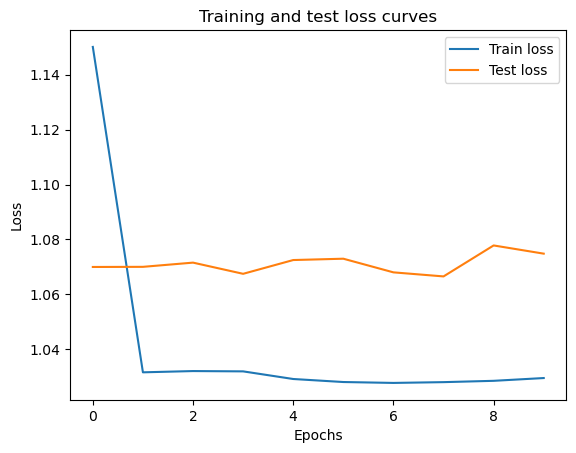

In [72]:
## - Plot loss curve
import plots
plots.plot_loss(epoch_count, train_loss, test_loss)

##

In [73]:
# Transfer Learning
pretrained_vitweights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vitmodel = torchvision.models.vit_b_16(weights=pretrained_vitweights).to(device)

# Selecting prefered parameters
for parameter in pretrained_vitmodel.parameters():
    parameter.requires_grad = False
    
    
# Setting up output channel
pretrained_vitmodel.heads = nn.Linear(in_features=768, out_features = len(class_names)).to(device)

In [74]:
# Data prep
import data_prep_pretrained # this is mine
batch_size = 32
image_size = (224, 224)


data_transform_pretrained = pretrained_vitweights.transforms()
train_dataloader, test_dataloader, val_dataloader, y_train, y_test, y_val, class_names = data_prep_pretrained.data_prep_archive(batch_size, image_size, data_transform_pretrained)

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/2831 [00:00<?, ?it/s]

  0%|          | 0/1840 [00:00<?, ?it/s]

In [75]:
# Train and test
import train_test
## - Setup hyperparameters and run
num_epochs = 5
lr = 0.003

train_loss, test_loss, epoch_count = train_test.train_test(pretrained_vitmodel, lr, num_epochs, train_dataloader, test_dataloader, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1083 | train_acc: 0.9923 | test_loss: 0.2842 | test_acc: 0.9603
Epoch: 2 | train_loss: 0.0927 | train_acc: 0.9987 | test_loss: 0.2849 | test_acc: 0.9613
Epoch: 3 | train_loss: 0.0924 | train_acc: 0.9983 | test_loss: 0.2820 | test_acc: 0.9631
Epoch: 4 | train_loss: 0.0931 | train_acc: 0.9985 | test_loss: 0.2770 | test_acc: 0.9557
Epoch: 5 | train_loss: 0.0928 | train_acc: 0.9986 | test_loss: 0.2930 | test_acc: 0.9564


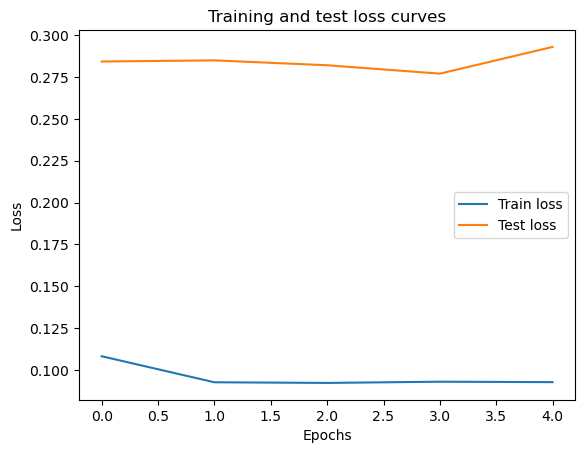

In [76]:
## - Plot loss curve
import plots
plots.plot_loss(epoch_count, train_loss, test_loss)

In [77]:
import predict
predict_ = predict.predict_test(pretrained_vitmodel,
                                val_dataloader,
                                device)

In [78]:
predict_.unique()

tensor([0, 1, 2])

In [79]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, predict_)

array([[632,   0,   8],
       [  1, 498,   1],
       [ 79,  15, 606]])

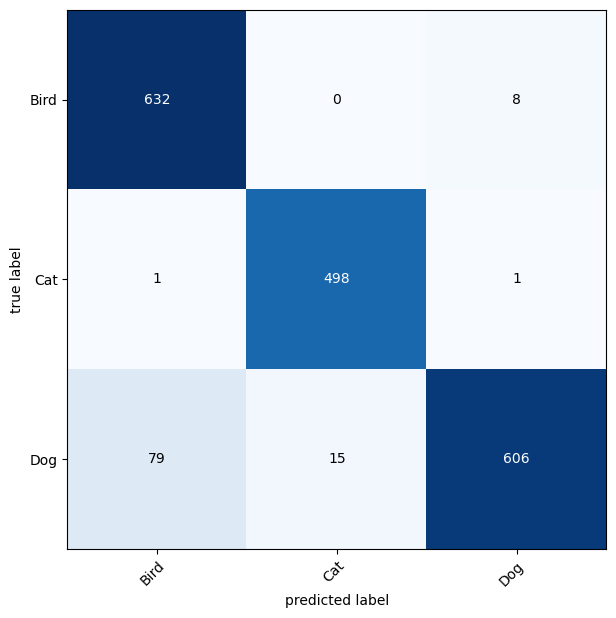

In [80]:
import plots

plots.plot_predictions_cm(class_names, y_val, predict_)

In [81]:
import predict

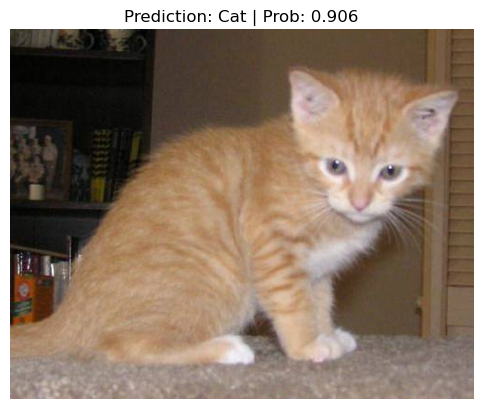

In [82]:
image_path  = 'predict_image.jpg'
predict.predict_unseen(pretrained_vitmodel, class_names, (224, 224), image_path, device)